In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import cv2
from keras.models import load_model
import os
import tensorflow as tf
from IPython.display import clear_output
import timeit

Using TensorFlow backend.


In [2]:
face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_alt.xml')
eye_cascade = cv2.CascadeClassifier('./haarcascade_eye.xml')
mouth_cascade = cv2.CascadeClassifier('./haarcascade_smile.xml')
FRmodel = load_model('./face-rec_Google.h5')

/usr/local/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
# helmet = load_model('./GogglesAndHelmet.h5')
helmet = load_model('./Face_Gesture_Recogizer_Final_1.h5')

In [4]:
print(FRmodel.count_params())

3743280


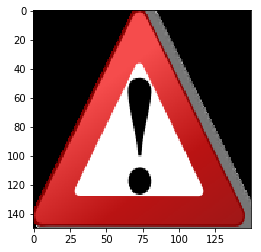

(150, 150, 3)


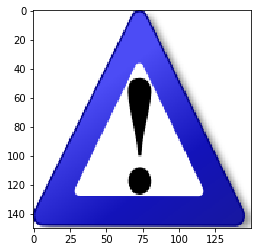

In [5]:
alert = cv2.cvtColor(cv2.imread('./Shipping_Alert.png'),cv2.COLOR_BGR2RGB)
alert_alpha = cv2.imread('./Shipping_Alert.png',cv2.IMREAD_UNCHANGED)
alert = cv2.resize(alert,(150,150))
alert_alpha = cv2.resize(alert_alpha,(150,150))
plt.imshow(alert)
plt.show()
plt.imshow(alert_alpha)
print(alert.shape)

In [6]:
card_data = pd.read_csv('./Card Data.csv')
card_data.head()

,Card Type,Card Number,CVV,Expires
0,Visa,4556035157638848,397,04/2022
1,MasterCard,4716487626397851,395,12/2022
2,Visa,4916353991301746,316,03/2023
3,Visa,4929299429259144,780,05/2023
4,MasterCard,5276921737271851,145,04/2021


In [7]:
def img_to_embedding(image, model):
    image = cv2.resize(image, (96, 96)) 
    img = image[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    x_train = np.array([img])
    embedding = model.predict(x_train)
    return embedding

In [8]:
def distance(x1,x2):
    return np.sqrt(((x2-x1)**2).sum())

In [9]:
def helmetPredict(cur):
    fin_img = cv2.resize(cur, (100,100) )
    fin_img = np.array(fin_img)
    fin_img = fin_img.reshape( (1,100,100,3) )
    fin_img = fin_img/255.0
    result = helmet.predict( fin_img )
    num = np.argmax( result[0] )
    return num

In [10]:
def embedding_present(emb,thresh,cur_card):
    # TO DO
    ctr=0
    face_data = []
    card_data = []
    for ix in os.listdir('./data_today/'):
        if ix.endswith('.npy'):
            data_item = np.load('./data_today/' + str(ix))
            card_no = data_item[-1]
            data_item = data_item[:-1]
#             print(data_item)
            face_data.append(data_item)
            card_data.append(card_no)
            ctr += 1
    idx = 0
    for ix in face_data:
#         print(distance(ix,emb))
#         print(card_data[idx])
        if distance(ix,emb)<thresh and cur_card==card_data[idx]:
            return 0,ctr
        if distance(ix,emb)<thresh and cur_card!=card_data[idx]:
            return 1,ctr
        idx+=1
    return 2,ctr

In [11]:
def initialSetup():
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    start_time = timeit.default_timer()

    # This takes 2-5 seconds to run
    # Unpersists graph from file
    with tf.gfile.FastGFile('./retrained_graph.pb', 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')
        
initialSetup()

In [24]:
from tkinter import *
def show_entry_fields():
    global card_no,cvv
    card_no = e1.get()
    cvv = e2.get()


master = Tk()
Label(master, text="Card Number").grid(row=0)
Label(master, text="CVV").grid(row=1)

e1 = Entry(master)
e2 = Entry(master)

e1.grid(row=0, column=1)
e2.grid(row=1, column=1)

Button(master, text='Quit', command=master.quit).grid(row=3, column=0, sticky=W, pady=4)
Button(master, text='Show', command=show_entry_fields).grid(row=3, column=1, sticky=W, pady=4)

mainloop( )
print(cvv,card_no)

768 2341


In [25]:
label_lines = [line.rstrip() for line
               in tf.gfile.GFile('./retrained_labels.txt')]
with tf.Session() as sess:
    tf.initialize_all_variables().run()
    start_time = timeit.default_timer()

    # Feed the image_data as input to the graph and get first prediction
    softmax_tensor = sess.graph.get_tensor_by_name('final_result:0')
    
    card_no = float(card_no)
    cvv = float(cvv)
    start = False
    temp = False
    cap = cv2.VideoCapture(0)
    count=1
    while True:
        ret, frame = cap.read()
        if ret==False:
            continue
        frame = cv2.flip(frame, 1)
        
        frame_gun = cv2.resize(frame, (299, 299), interpolation=cv2.INTER_CUBIC)
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(frame, 1.3, 5)
        faces = sorted(faces, key=lambda x: x[2]*x[3], reverse=True)
        
        # press q to quit
        key = cv2.waitKey(1)
        if key==113:
            break
            
        # adhere to TS graph input structure
        numpy_frame = np.asarray(frame_gun)
        numpy_frame = cv2.normalize(numpy_frame.astype('float'), None, -0.5, .5, cv2.NORM_MINMAX)
        numpy_final = np.expand_dims(numpy_frame, axis=0)
        
        start_time = timeit.default_timer()

        # This takes 2-5 seconds as well
        predictions = sess.run(softmax_tensor, {'Mul:0': numpy_final})
        score = predictions.item(1)
        gunScore =str(score)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        if score>0.85:
            cv2.putText(frame, "WEAPON DETECTED ("+gunScore + ")", (10,20), font, 0.8, (0, 0, 255), 2)
            alpha = alert_alpha[:,:,3]/255.0
            alert=cv2.cvtColor(alert,cv2.COLOR_BGR2RGB)
            frame[20:170,1100:1250, 0] = frame[20:170,1100:1250, 0] * (1-alpha) + alpha * alert[:,:,0]
            frame[20:170,1100:1250, 1] = frame[20:170,1100:1250, 1] * (1-alpha) + alpha * alert[:,:,1]
            frame[20:170,1100:1250, 2] = frame[20:170,1100:1250, 2] * (1-alpha) + alpha * alert[:,:,2]
        else:
            cv2.putText(frame, "NO WEAPON DETECTED ("+gunScore + ")", (10,20), font, 0.8, (0, 255, 0), 2)
        
        
        start_time = timeit.default_timer()

        # Sort to show labels of first prediction in order of confidence
        top_k = predictions[0].argsort()[-len(predictions[0]):][::-1]
        
        
        for node_id in top_k:
            human_string = label_lines[node_id]
            score = predictions[0][node_id]
            print('%s (score = %.5f)' % (human_string, score))
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        
#         cv2.imshow('Main', frame)

        
        for face in faces[:1]:
            x,y,w,h = face
            offset = 7
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
            roi_gray = gray[y:y+h, x:x+w]
            roi_color = frame[y:y+h, x:x+w]
        
            eyes = eye_cascade.detectMultiScale(roi_gray)
            mouths = mouth_cascade.detectMultiScale(roi_gray)
            eyes = sorted(eyes, key=lambda x: x[2]*x[3], reverse=True)
            mouths = sorted(mouths, key=lambda x: x[2]*x[3], reverse=True)
            if len(mouths)>0:
                mx,my,mw,mh = mouths[0]
                cv2.rectangle(roi_color,(mx,my),(mx+mw,my+mh),(0,0,255),2)
            for ix in range(len(eyes)):
                if ix>1:
                    continue
                ex,ey,ew,eh = eyes[ix]
                cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
            face_section = frame[y-offset:y+h+offset,x-offset:x+w+offset]
            face_section = cv2.resize(face_section,(100,100))
            helmetCheck = helmetPredict(face_section)
            print(helmetCheck)
            if helmetCheck==3:
                cv2.putText(frame, "Remove helmet and sunglasses", (10,40), font, 0.8, (0, 0, 255), 2)
                alpha = alert_alpha[:,:,3]/255.0
                alert=cv2.cvtColor(alert,cv2.COLOR_BGR2RGB)
                frame[20:170,1100:1250, 0] = frame[20:170,1100:1250, 0] * (1-alpha) + alpha * alert[:,:,0]
                frame[20:170,1100:1250, 1] = frame[20:170,1100:1250, 1] * (1-alpha) + alpha * alert[:,:,1]
                frame[20:170,1100:1250, 2] = frame[20:170,1100:1250, 2] * (1-alpha) + alpha * alert[:,:,2]
            emb = img_to_embedding(face_section,FRmodel)
            emb=np.reshape(emb,(128,))
            pre, ctr = embedding_present(emb,0.1,card_no)
            if(pre==0):
#                 print("FINE")
                temp=True
            elif pre==1 or helmetCheck==2:
                print("ALARM")
                cv2.putText(frame, "Card Mismatch", (10,60), font, 0.8, (0, 0, 255), 2)
                alpha = alert_alpha[:,:,3]/255.0
                alert=cv2.cvtColor(alert,cv2.COLOR_BGR2RGB)
                frame[20:170,1100:1250, 0] = frame[20:170,1100:1250, 0] * (1-alpha) + alpha * alert[:,:,0]
                frame[20:170,1100:1250, 1] = frame[20:170,1100:1250, 1] * (1-alpha) + alpha * alert[:,:,1]
                frame[20:170,1100:1250, 2] = frame[20:170,1100:1250, 2] * (1-alpha) + alpha * alert[:,:,2]
            else:
                # Save Embedding
                print("SAVING")
                temp = True
                emb = np.append(emb,card_no)
                np.save('./data_today/' + str(ctr), emb)
                ctr+=1
        cv2.imshow("Faces", frame)
cap.release()
cv2.destroyAllWindows()

person (score = 0.58890)
person handgun (score = 0.41110)
0
ALARM
person (score = 0.50939)
person handgun (score = 0.49061)
2
ALARM
person (score = 0.61640)
person handgun (score = 0.38360)
2
ALARM
person (score = 0.57995)
person handgun (score = 0.42005)
2
ALARM
person (score = 0.53650)
person handgun (score = 0.46350)
2
ALARM
person (score = 0.58355)
person handgun (score = 0.41645)
2
ALARM
person (score = 0.59758)
person handgun (score = 0.40242)
0
ALARM
person (score = 0.58334)
person handgun (score = 0.41666)
2
ALARM
person (score = 0.65822)
person handgun (score = 0.34178)
0
ALARM
person (score = 0.69225)
person handgun (score = 0.30775)
2
ALARM
person (score = 0.57208)
person handgun (score = 0.42792)
0
ALARM
person (score = 0.59296)
person handgun (score = 0.40704)
0
ALARM
person (score = 0.66750)
person handgun (score = 0.33250)
0
ALARM
person (score = 0.60785)
person handgun (score = 0.39215)
2
ALARM
person (score = 0.63873)
person handgun (score = 0.36127)
2
ALARM
person (sc